In [1]:
import numpy as np
from scipy.optimize import linprog
import pandas as pd
import numpy as np

1. Récupération des données

In [ ]:
N = 3
fichiers_production = ['prodA.csv', 'prodB.csv', 'prodC.csv']
fichier_demande = 'demand2050_ademe.csv'

a. Traitement des fichiers de production (prodA, prodB, prodC)

In [13]:
liste_production_series = []

print("Chargement des fichiers de production...")
for nom_fichier in fichiers_production:
    try:
        df = pd.read_csv(nom_fichier)
        # On ajoute la colonne 'Production_Elec' convertie en float
        liste_production_series.append(df['Production_Elec'].astype(float))
        print(f"  - {nom_fichier} chargé avec succès.")
    except FileNotFoundError:
        print(f"Erreur : Le fichier {nom_fichier} n'a pas été trouvé.")

if liste_production_series:
    # Concaténation en une seule DataFrame avec colonnes pour chaque production
    # On s'assure que toutes les séries ont la même longueur
    min_len = min(len(s) for s in liste_production_series)
    # Tronque toutes les séries à la même longueur
    liste_tronquee = [s[:min_len] for s in liste_production_series]
    
    # Transformation en DataFrame (colonnes = prodA, prodB, prodC)
    df_production = pd.DataFrame({
        f'prod{i+1}': serie for i, serie in enumerate(liste_tronquee)
    })
    
    # Conversion en matrice numpy
    matrice_production = df_production.to_numpy()
    print("Matrice de production créée avec succès.")
else:
    matrice_production = np.array([])
    print("Aucun fichier de production n'a pu être chargé. La matrice est vide.")


Chargement des fichiers de production...
  - prodA.csv chargé avec succès.
  - prodB.csv chargé avec succès.
  - prodC.csv chargé avec succès.
Matrice de production créée avec succès.


b. Traitement du fichier de demande (demand2050_ademe.csv)

In [18]:
print("\nChargement du fichier de demande...")
try:
    df_demande = pd.read_csv(fichier_demande, header=None)
    vecteur_demande = df_demande.iloc[:, 1].astype(float).to_numpy()

    if matrice_production.size > 0:
        n_lignes, n_colonnes = matrice_production.shape
        # Nombre d’éléments par colonne
        L = len(vecteur_demande)
        taille_colonne = int(np.ceil(L / n_colonnes))

        # Créer une matrice vide
        matrice_demande = np.zeros((n_lignes, n_colonnes))

        for i in range(n_colonnes):
            start = i * taille_colonne
            end = start + n_lignes
            # Extraire la partie correspondante et compléter si nécessaire
            partie = vecteur_demande[start:end]
            if len(partie) < n_lignes:
                # compléter avec la dernière valeur de la partie
                partie = np.concatenate([partie, np.full(n_lignes - len(partie), partie[-1])])
            matrice_demande[:, i] = partie

    else:
        matrice_demande = np.array([])
        print("La matrice de production est vide, la matrice de demande ne peut pas être alignée.")

    print("Matrice de demande créée avec succès.")

except FileNotFoundError:
    matrice_demande = np.array([])
    print(f"Erreur : Le fichier {fichier_demande} n'a pas été trouvé.")

    
print(np.shape(matrice_demande))
print(np.shape(matrice_production))
print(matrice_demande)




Chargement du fichier de demande...
Matrice de demande créée avec succès.
(2920, 3)
(2920, 3)
[[28.6900142 52.2312379 45.2468095]
 [31.2084578 46.3139339 56.6973334]
 [27.6996061 46.33277   62.0020965]
 ...
 [58.1660071 31.6128117 36.7066712]
 [56.1246215 33.0292104 33.2898536]
 [54.4065208 37.3809909 28.6056381]]


Les deux matrices sont maintenant disponibles dans les variables `matrice_production` et `matrice_demande`.

- prod : matrice où les lignes representent pour chaque heure (prodA, prodB, prodC)
- demand : matrice où les lignes representent pour chaque heure (demandA, demandB, demandC)
- qmax : capacité maximale de flux entre deux pays
- N : nombre de pays
- T : nombre de périodes

In [ ]:
qmax = 100
N,T=np.shape(matrice_demande)
print(N)
print(T)

2920
3


2. Ecriture de l'algorithme de résolution

In [22]:
def solve_flux(prod_matrix, demand_matrix, qmax):
    """
    Résout le flux optimal pour N pays et T périodes, à partir des matrices de production et de demande.
    
    prod_matrix : np.array de shape (T, N)
    demand_matrix : np.array de shape (T, N)
    qmax : float, capacité maximale des flux
    """
    prod_matrix = np.array(prod_matrix)
    demand_matrix = np.array(demand_matrix)
    
    T, N = prod_matrix.shape

    n_q = N*(N-1)*T
    offset_r_pos = n_q
    offset_r_neg = n_q + N*T
    nvar = n_q + 2*N*T

    c = np.zeros(nvar)
    c[offset_r_neg: offset_r_neg + N*T] = 1.0  # On minimise les r_neg

    A_eq = []
    b_eq = []

    def q_index(i, j, t):
        if i == j:
            raise ValueError("i should not equal j")
        return t*N*(N-1) + i*(N-1) + (j if j < i else j - 1)

    # Construction des contraintes d'égalité
    for t in range(T):
        for i in range(N):
            row = np.zeros(nvar)
            for j in range(N):
                if i != j:
                    row[q_index(i, j, t)] -= 1  # sortie
                    row[q_index(j, i, t)] += 1  # entrée
            # r_pos - r_neg = prod - demand
            row[offset_r_pos + i + t*N] = 1
            row[offset_r_neg + i + t*N] = -1
            A_eq.append(row)
            b_eq.append(prod_matrix[t, i] - demand_matrix[t, i])

    A_eq = np.array(A_eq)
    b_eq = np.array(b_eq)

    Q = prod_matrix - demand_matrix

    # --- BOUNDS ---
    bounds = []

    # 1) bornes pour q
    for t in range(T):
        for i in range(N):
            for j in range(N):
                if i != j:
                    bounds.append((0, qmax))
    
    # 2) bornes pour r_pos
    for t in range(T):
        for i in range(N):
            if Q[t, i] >= 0:
                bounds.append((0, None))
            else:
                bounds.append((0, 0))
    
    # 3) bornes pour r_neg
    for t in range(T):
        for i in range(N):
            if Q[t, i] >= 0:
                bounds.append((0, 0))
            else:
                bounds.append((0, None))
    
    # Solve LP
    res = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method="highs")
    if not res.success:
        raise RuntimeError("Optimization failed:", res.message)

    x = res.x

    # Reconstruction des flux q
    q = np.zeros((T, N, N))
    idx = 0
    for t in range(T):
        for i in range(N):
            for j in range(N):
                if i != j:
                    q[t, i, j] = x[idx]
                    idx += 1

    r_pos = x[offset_r_pos:offset_r_pos + N*T].reshape(T, N)
    r_neg = x[offset_r_neg:offset_r_neg + N*T].reshape(T, N)

    eps = 1e-9
    r_pos = np.where(np.abs(r_pos) < eps, 0.0, r_pos)
    r_neg = np.where(np.abs(r_neg) < eps, 0.0, r_neg)

    return q, r_pos, r_neg


3. Récupération des tests

In [25]:
q, r_pos, r_neg = solve_flux(matrice_production, matrice_demande, qmax)


T, N = r_pos.shape  # nombre de périodes et de pays

# Statistiques globales
nb_r_pos_positifs = np.sum(r_pos > 0)
nb_r_neg_positifs = np.sum(r_neg > 0)

print("----- Statistiques r⁺ et r⁻ (global) -----")
print("nb heures total :", T * N)
print("nb_r_pos_positifs:", nb_r_pos_positifs)
print("nb_r_neg_positifs:", nb_r_neg_positifs)
print("proportion de r negatifs", nb_r_neg_positifs / (T * N))
print("somme des r :", nb_r_pos_positifs + nb_r_neg_positifs)
print("---------------------------------------")

# Statistiques par pays
for i, pays in enumerate(["A", "B", "C"]):
    nb_r_pos = np.sum(r_pos[:, i] > 0)
    nb_r_neg = np.sum(r_neg[:, i] > 0)
    print(f"Pays {pays}:")
    print("nb_r_pos_positifs:", nb_r_pos)
    print("nb_r_neg_positifs:", nb_r_neg)
    print("proportion de r negatifs", nb_r_neg / T)
    print("---------------------------------------")


----- Statistiques r⁺ et r⁻ (global) -----
nb heures total : 8760
nb_r_pos_positifs: 7598
nb_r_neg_positifs: 953
proportion de r negatifs 0.10878995433789955
somme des r : 8551
---------------------------------------
Pays A:
nb_r_pos_positifs: 2376
nb_r_neg_positifs: 458
proportion de r negatifs 0.15684931506849314
---------------------------------------
Pays B:
nb_r_pos_positifs: 2664
nb_r_neg_positifs: 193
proportion de r negatifs 0.06609589041095891
---------------------------------------
Pays C:
nb_r_pos_positifs: 2558
nb_r_neg_positifs: 302
proportion de r negatifs 0.10342465753424658
---------------------------------------


4. Interprétation graphique

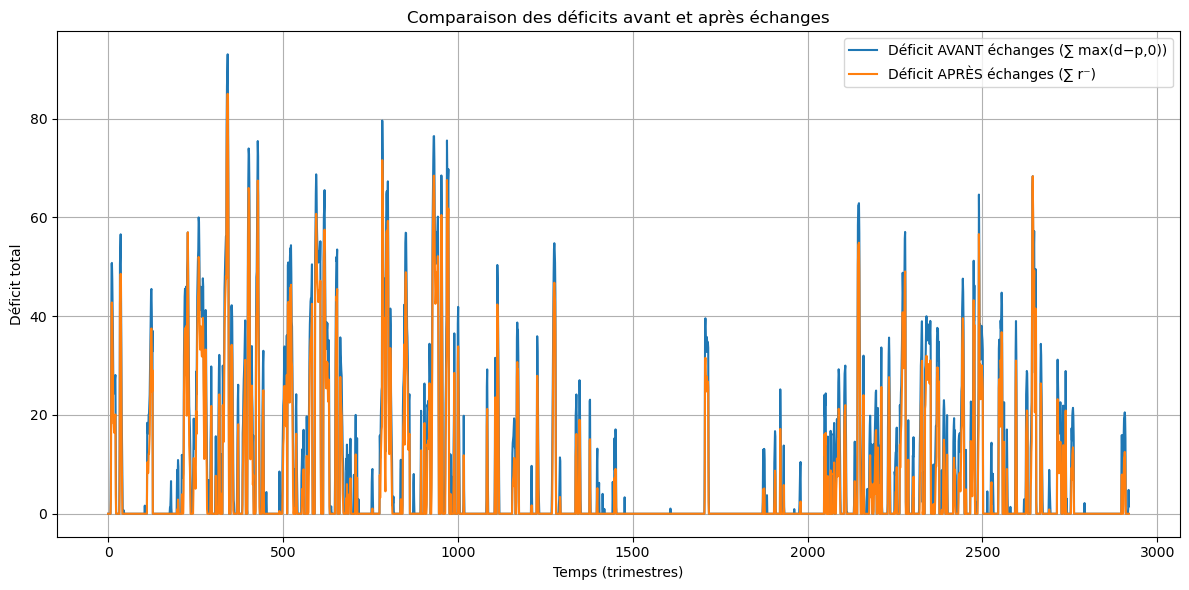

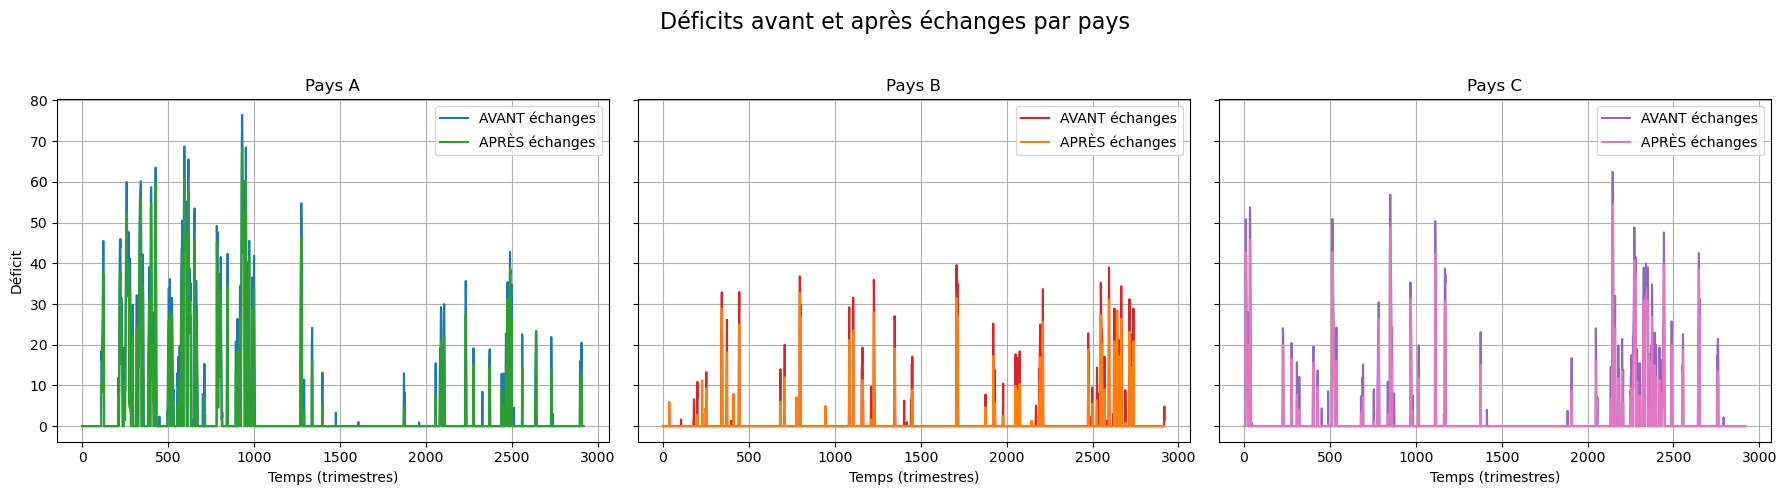

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# r_neg est déjà une matrice (T, N)
r_neg_sum = np.sum(r_neg, axis=1)  # somme par ligne → déficit total après échanges

# Déficit avant échanges
raw_deficit = np.maximum(matrice_demande - matrice_production, 0)
raw_deficit_sum = np.sum(raw_deficit, axis=1)  # somme par ligne → déficit total avant échanges

# Tracé
plt.figure(figsize=(12, 6))
plt.plot(raw_deficit_sum, label="Déficit AVANT échanges (∑ max(d−p,0))")
plt.plot(r_neg_sum, label="Déficit APRÈS échanges (∑ r⁻)")


plt.title("Comparaison des déficits avant et après échanges")
plt.xlabel("Temps (trimestres)")
plt.ylabel("Déficit total")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

pays_labels = ["A", "B", "C"]
couleurs_avant = ["tab:blue", "tab:red", "tab:purple"]
couleurs_apres = ["tab:green", "tab:orange", "tab:pink"]

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)  # 1 ligne, 3 colonnes

for i, ax in enumerate(axes):

    ax.plot(np.maximum(matrice_demande[:, i] - matrice_production[:, i], 0), color=couleurs_avant[i], label="AVANT échanges")
    ax.plot(r_neg[:, i], color=couleurs_apres[i], label="APRÈS échanges")

    ax.set_title(f"Pays {pays_labels[i]}")
    ax.set_xlabel("Temps (trimestres)")
    ax.grid(True)
    if i == 0:
        ax.set_ylabel("Déficit")
    ax.legend()

plt.suptitle("Déficits avant et après échanges par pays", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajuste l'espace pour le suptitle
plt.show()

